### Offshore dataset

Date: 19 March 2025

##### 0. Loading necessary libraries and setting random seed

In [7]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import StandardScaler

In [8]:
# Set random seed
np.random.seed(42)

##### 1.Retreiving data

In [9]:
# Get the data
db_offshore = pd.read_csv('https://raw.githubusercontent.com/benrodion/Watts-next/main/data/final_offshore_data_2017_2025.csv')
#db_offshore = pd.read_csv('/Users/kirillkharlashkin/Documents/Hertie Github repos/Watts-next/data/final_offshore_data_2017_2025.csv')

In [10]:
# Get the head rows of the data
db_offshore.head(3)

,year_mon_day,hour,wind_dir_avg_10,wind_speed_h_avg,wind_speed_avg_10,air_pressure,humidity,full_datetime,capacity,volume,percentage,emission,emissionfactor,correct_days
0,20170101,1,213.586816,85.714286,86.428571,10206.75,95.714286,2017-01-01-01,873501,873501,1.014165,0,0,2017-01-01-01
1,20170101,2,210.905296,87.142857,90.714286,10199.75,96.142857,2017-01-01-02,883749,883749,1.026065,0,0,2017-01-01-02
2,20170101,3,208.585001,89.285714,87.857143,10191.50,96.000000,2017-01-01-03,872500,872500,1.013004,0,0,2017-01-01-03


#### 2. Limiting the data to 5-year span (2020-2024)

In [11]:
# Extract the date in YYYY-MM-DD format
db_offshore['date'] = db_offshore['full_datetime'].str.rsplit('-', n=1).str[0]
db_offshore.head(1)

,year_mon_day,hour,wind_dir_avg_10,wind_speed_h_avg,wind_speed_avg_10,air_pressure,humidity,full_datetime,capacity,volume,percentage,emission,emissionfactor,correct_days,date
0,20170101,1,213.586816,85.714286,86.428571,10206.75,95.714286,2017-01-01-01,873501,873501,1.014165,0,0,2017-01-01-01,2017-01-01


In [12]:
# Limit the db to the last 5 years (2020-2024) and removing data for '2025-01-01'
db_offshore = db_offshore[(db_offshore['date'] >= '2020-01-01') & (db_offshore['date'] < '2025-01-01')]
db_offshore.tail(1)

,year_mon_day,hour,wind_dir_avg_10,wind_speed_h_avg,wind_speed_avg_10,air_pressure,humidity,full_datetime,capacity,volume,percentage,emission,emissionfactor,correct_days,date
70127,20241231,24,214.005693,152.666667,153.333333,10109.5,87.428571,2024-12-31-24,3453249,3453249,0.830507,0,0,2024-12-31-24,2024-12-31


In [13]:
# Convert 'correct days' to datetype format for further processing
db_offshore[['date', 'hour']] = db_offshore['correct_days'].str.rsplit('-', n=1, expand=True)

db_offshore['hour'] = db_offshore['hour'].astype(int) - 1

db_offshore['datetime'] = pd.to_datetime(db_offshore['date']) + pd.to_timedelta(db_offshore['hour'], unit='H')

/var/folders/6x/v5640c0d6tjd96p_48y5_sy40000gn/T/ipykernel_80141/318064267.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  db_offshore['datetime'] = pd.to_datetime(db_offshore['date']) + pd.to_timedelta(db_offshore['hour'], unit='H')


In [14]:
# Check what share of data belongs to 2024
print((db_offshore['date'] >= '2024-01-01').sum() / db_offshore['date'].count())

0.20032840722495895


#### 3. Analysing the seasonality and stationarity of data

In [15]:
# Load libraries
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [16]:
# Set 'datetime' as index for the dataset
db_offshore.set_index('datetime', inplace=True)
db_offshore.head(3)

,year_mon_day,hour,wind_dir_avg_10,wind_speed_h_avg,wind_speed_avg_10,air_pressure,humidity,full_datetime,capacity,volume,percentage,emission,emissionfactor,correct_days,date
datetime,,,,,,,,,,,,,,,
2020-01-01 00:00:00,20200101,0,156.685099,48.000000,48.666667,10344.25,98.000000,2020-01-01-01,116000,116000,0.134680,0,0,2020-01-01-01,2020-01-01
2020-01-01 01:00:00,20200101,1,153.528919,50.000000,50.666667,10339.25,97.571429,2020-01-01-02,110500,110500,0.128294,0,0,2020-01-01-02,2020-01-01
2020-01-01 02:00:00,20200101,2,155.998588,47.333333,46.000000,10333.25,98.000000,2020-01-01-03,135251,135251,0.157031,0,0,2020-01-01-03,2020-01-01


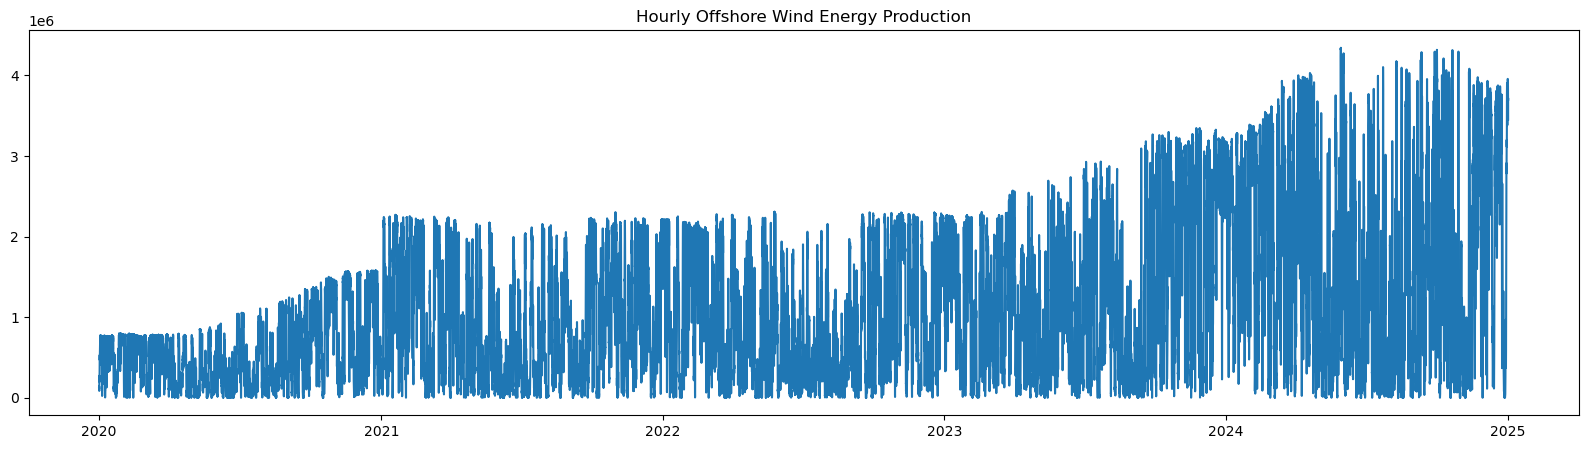

In [17]:
# Build basic time series plot for the 'volume'
plt.figure(figsize=(20, 5))
plt.plot(db_offshore.index, db_offshore['volume'])
plt.title('Hourly Offshore Wind Energy Production')
plt.show()

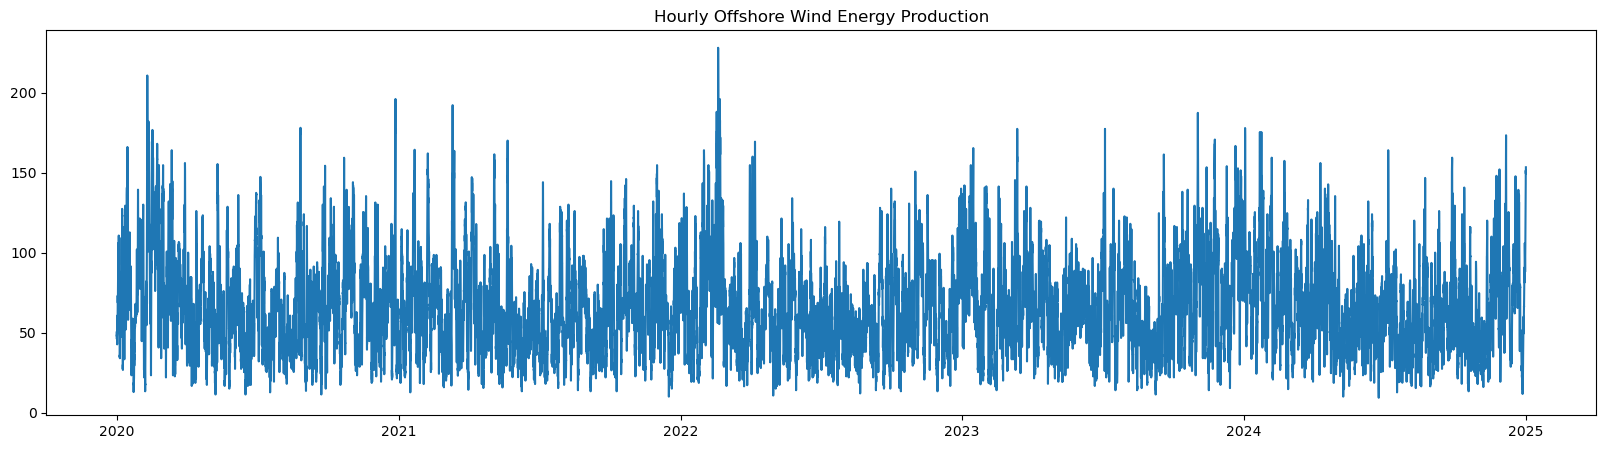

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(db_offshore.index, db_offshore['wind_speed_avg_10'])
plt.title('Hourly Offshore Wind Energy Production')
plt.show()

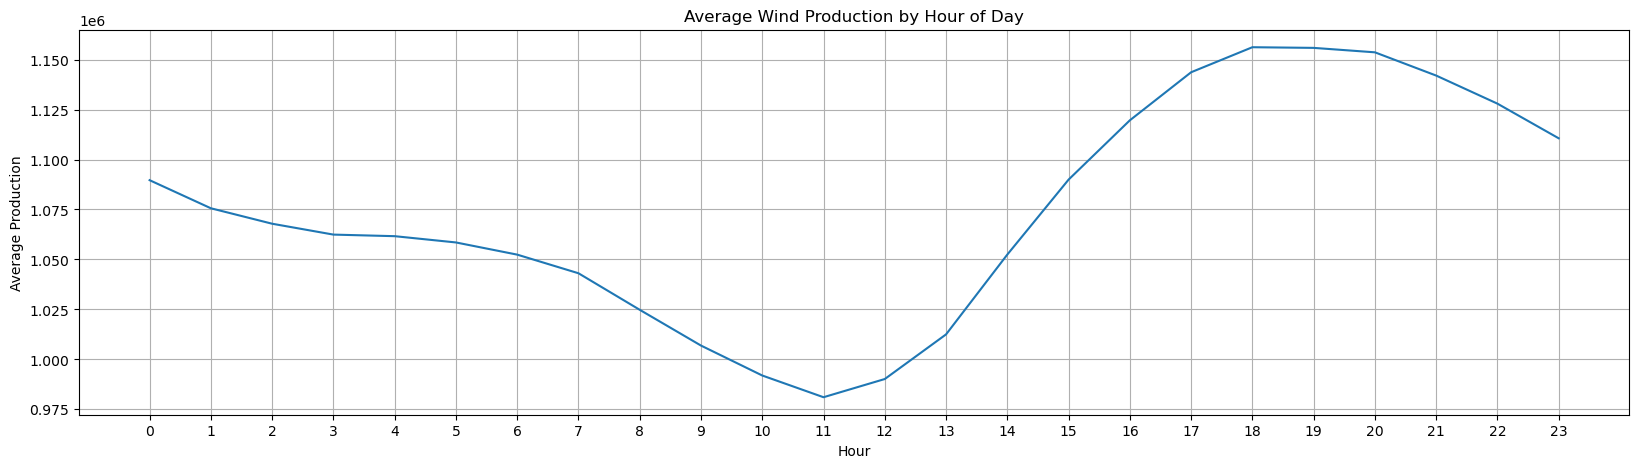

In [19]:
# Check daily patterns (average production by hour of day)
hourly_avg = db_offshore.groupby(db_offshore.index.hour)['volume'].mean()
plt.figure(figsize=(20, 5))
plt.plot(hourly_avg.index, hourly_avg.values)
plt.title('Average Wind Production by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Production')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

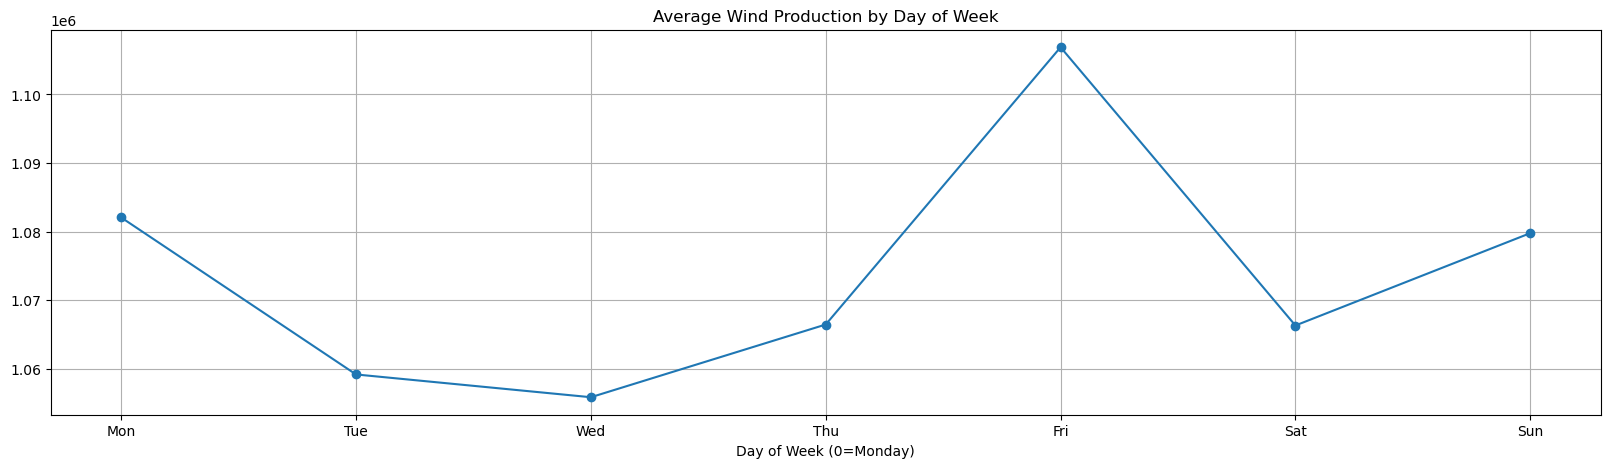

In [20]:
# Check weekly patterns (average by day of week)
daily_avg = db_offshore.groupby(db_offshore.index.dayofweek)['volume'].mean()
plt.figure(figsize=(20, 5))
plt.plot(daily_avg.index, daily_avg.values, marker='o')
plt.title('Average Wind Production by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.xticks(range(0, 7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

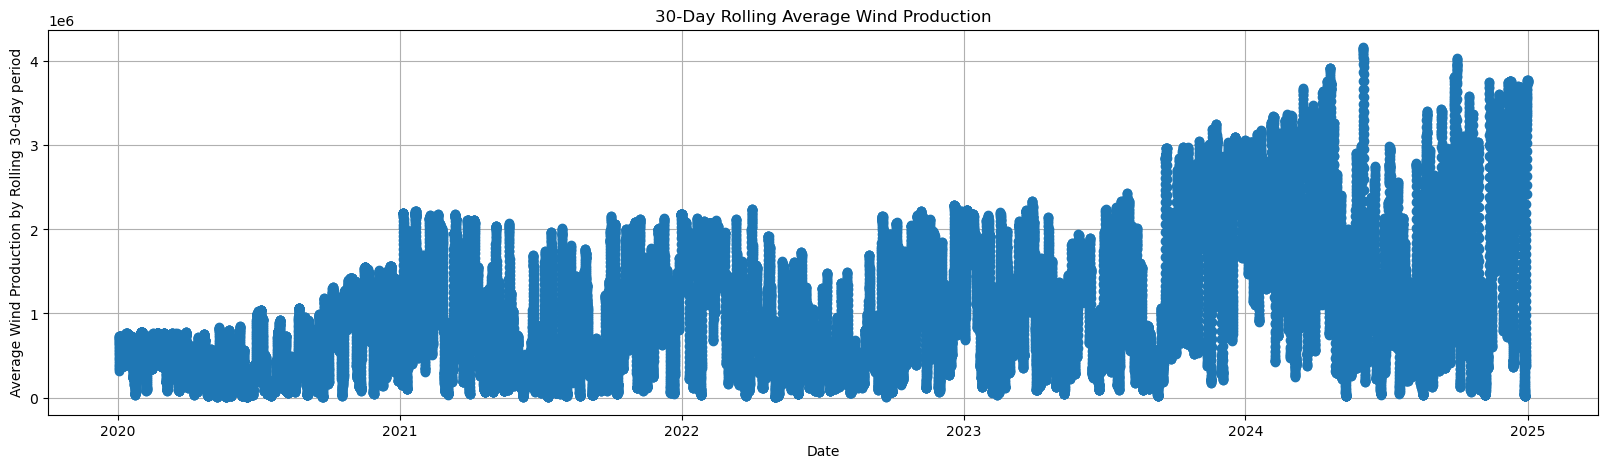

In [21]:
# Check 30-day (rolling) seasonality
rolling_avg = db_offshore['volume'].rolling(window=30).mean()
plt.figure(figsize=(20, 5))
plt.plot(rolling_avg.index, rolling_avg.values, marker='o')
plt.title('30-Day Rolling Average Wind Production')
plt.xlabel('Date')
plt.ylabel('Average Wind Production by Rolling 30-day period')
plt.grid(True)
plt.show()

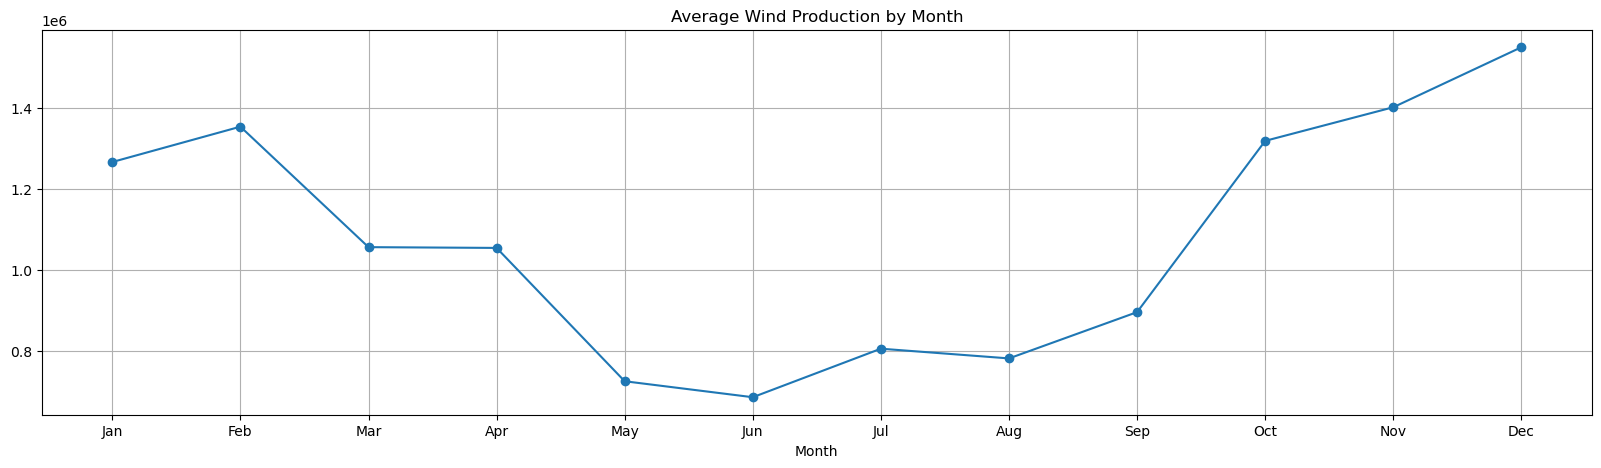

In [22]:
# Check monthly patterns
monthly_avg = db_offshore.groupby(db_offshore.index.month)['volume'].mean()
plt.figure(figsize=(20, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Average Wind Production by Month')
plt.xlabel('Month')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

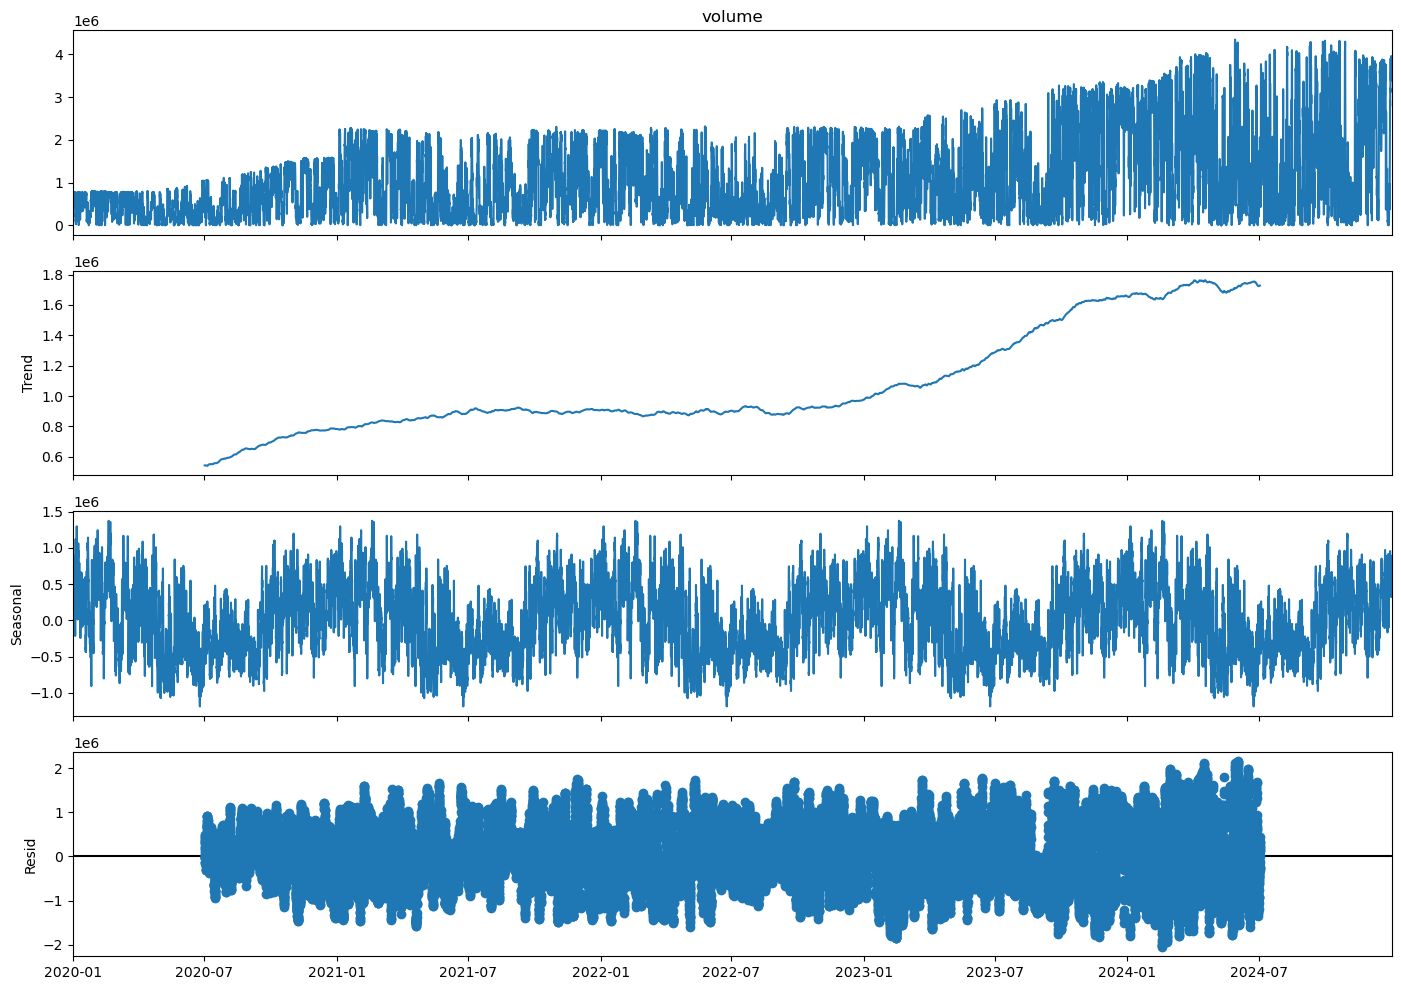

In [23]:
# Analyse annual seasonality with seasonal decomposition graphs
decomposition = seasonal_decompose(db_offshore['volume'], 
                                 model='additive', 
                                 period=8760)  # Annual seasonality
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

**Findings**:

1. Increasing trend

2. Annual seasonality confirmed and consistent across years

3. Residuals show an increasing variance over time (potential heteroscedasticity) 

**Suggestions for the SARIMAX model**:
- Base ARIMA component: Use (2,1,0) or (3,1,0) based on the clear trend shown here
- Seasonal component: Since annual seasonality is dominant, consider:
(a) Using dummy variables for months as exogenous variables
(b) Setting a more manageable seasonal period (s=24 for daily) while accounting for the annual pattern through exogenous variables
- Trend confirms the need for differencing (d=1) in your ARIMA component.

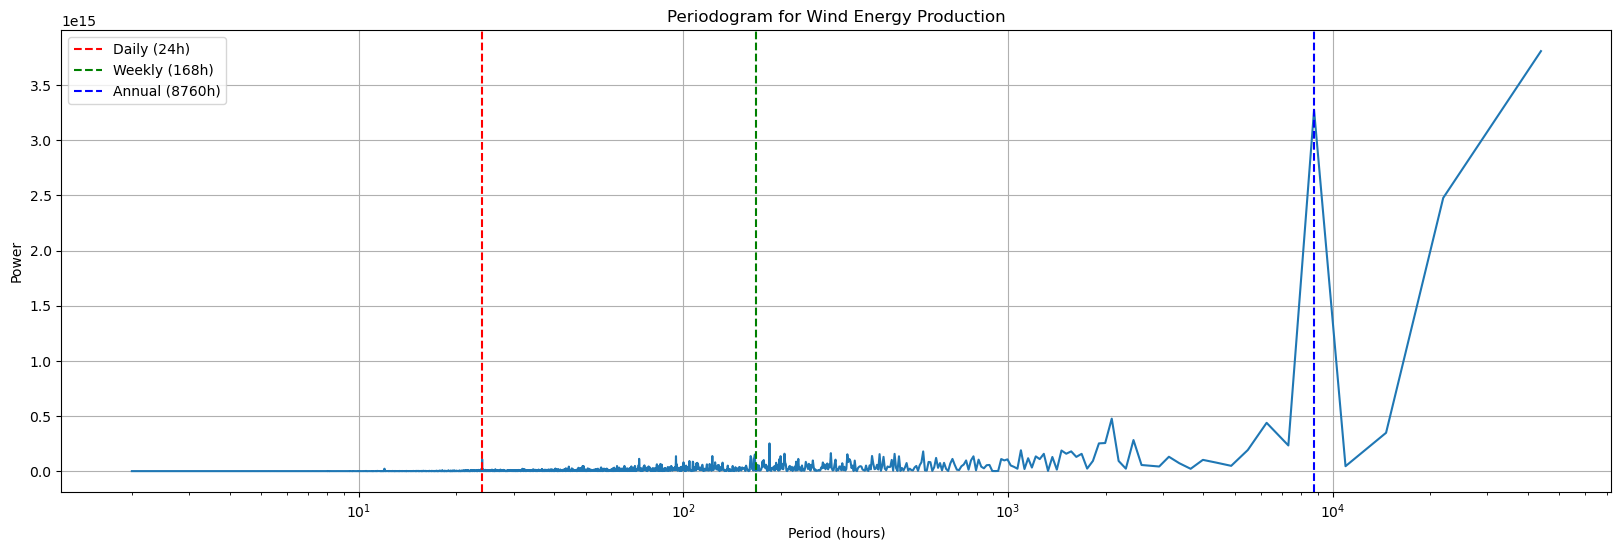

In [24]:
# Compute periodogram
f, Pxx = signal.periodogram(db_offshore['volume'].values, 
                           fs=1)  # 1 sample per hour

# Convert to periods in hours
periods = 1/f[1:]  # Skip the first element (DC component)
power = Pxx[1:]

plt.figure(figsize=(20, 6))
plt.plot(periods, power)
plt.title('Periodogram for Wind Energy Production')
plt.xlabel('Period (hours)')
plt.ylabel('Power')
plt.xscale('log')
plt.axvline(x=24, color='r', linestyle='--', label='Daily (24h)')
plt.axvline(x=168, color='g', linestyle='--', label='Weekly (168h)')
plt.axvline(x=8760, color='b', linestyle='--', label='Annual (8760h)')
plt.grid(True)
plt.legend()
plt.show()

**Findings:**

1. Annual seasonality dominates: the peak aligns almost perfectly with the annual cycle (8760h)
2. Daily and Weekly cycles are weak
3. The rising pattern at the far right indicates a long-term trend

**Suggestions for the SARIMAX model**:

- Seasonal component (s) should account for annual seasonality (s=8760), but this is computationally challenging for SARIMAX models.
- Alternatives:
- (a) Use s=24 or s=168 with an additional exogenous variable for month/season of year
- (b) Split the data by season and build separate models
- (c) Consider alternative models better suited for multiple seasonality:
- (c1) Prophet (can handle daily, weekly, annual seasonality simultaneously)
- (c2) TBATS (designed for complex seasonal patterns)
- (c3) Neural network models

For SARIMAX:
- ARIMA component: (2-3,1,0)
- Seasonal component: (1,1,0,24) as a computationally feasible option
- Add month-of-year dummy variables as exogenous regressors to capture the annual pattern.

In [25]:
# Plot ACF
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
#plot_acf(db_offshore['volume'], lags=8760, ax=ax1)  # 7 days of hourly data
#ax1.set_title('Autocorrelation Function (ACF)')

#plot_pacf(db_offshore['volume'], lags=8760, ax=ax2)
#ax2.set_title('Partial Autocorrelation Function (PACF)')
#plt.tight_layout()
#plt.show()

# Plots are computationally expensive (more than 5 minutes) for the expected seasonality (annual = 8760 h), return later

In [26]:
# ADF test
#result = adfuller(db_offshore['volume'].values)
#print(f'ADF Statistic: {result[0]}')
#print(f'p-value: {result[1]}')
#print('Critical Values:')
#for key, value in result[4].items():
    #print(f'\t{key}: {value}')

# Results are inclusive (dataset is stationary, no long-term trends), return later

#### 4. Try SARIMAX model

In [27]:
# Load libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
# Extract month as a dummy variable
db_offshore['year_month'] = pd.to_datetime(db_offshore['date']).dt.to_period('M').dt.to_timestamp()
db_offshore['year_month_numeric'] = (db_offshore['year_month'] - pd.to_datetime('2007-01-01')).dt.days // 30
db_offshore.head(3)

,year_mon_day,hour,wind_dir_avg_10,wind_speed_h_avg,wind_speed_avg_10,air_pressure,humidity,full_datetime,capacity,volume,percentage,emission,emissionfactor,correct_days,date,year_month,year_month_numeric
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,20200101,0,156.685099,48.000000,48.666667,10344.25,98.000000,2020-01-01-01,116000,116000,0.134680,0,0,2020-01-01-01,2020-01-01,2020-01-01,158
2020-01-01 01:00:00,20200101,1,153.528919,50.000000,50.666667,10339.25,97.571429,2020-01-01-02,110500,110500,0.128294,0,0,2020-01-01-02,2020-01-01,2020-01-01,158
2020-01-01 02:00:00,20200101,2,155.998588,47.333333,46.000000,10333.25,98.000000,2020-01-01-03,135251,135251,0.157031,0,0,2020-01-01-03,2020-01-01,2020-01-01,158


In [29]:
# Split the set to train and test
train_db = db_offshore[db_offshore['date'] < '2024-01-01']
test_db = db_offshore[db_offshore['date'] >= '2024-01-01']

In [30]:
# Identify the features and the label
feature_cols = ['year_month_numeric', 'wind_speed_avg_10']
X_train = train_db[feature_cols]
X_test = test_db[feature_cols]
y_train = train_db[['volume']]
y_test = test_db[['volume']]
print(X_train.shape)
print(y_train.shape) 
print(X_test.shape)
print(y_test.shape)

X_train.head(3)

(35064, 2)
(35064, 1)
(8784, 2)
(8784, 1)


,year_month_numeric,wind_speed_avg_10
datetime,,
2020-01-01 00:00:00,158,48.666667
2020-01-01 01:00:00,158,50.666667
2020-01-01 02:00:00,158,46.000000


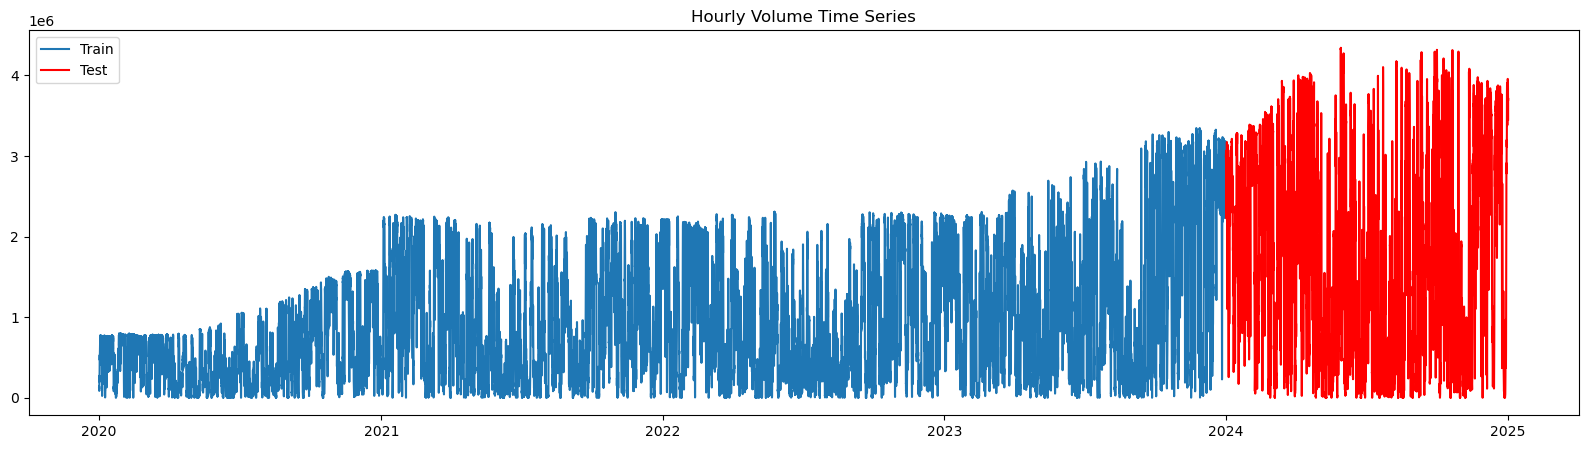

In [31]:
# Plot the target variable
plt.figure(figsize=(20,5))
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test", color='red')
plt.legend()
plt.title("Hourly Volume Time Series")
plt.show()

In [32]:
# Define and fit SARIMAX model (ATTENTION: takes 3min to fit)
#model = SARIMAX(y_train, 
                #exog=X_train, 
                #order=(3, 1, 0),  # ARIMA
                #seasonal_order=(1, 1, 0, 24))  # Seasonal ARIMA(P,D,Q,s)

#model_fit = model.fit(disp=True)

In [33]:
# Predict 
#predictions = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test, dynamic=False)

In [34]:
# Plot predictions
# I got very poor predictions
#plt.figure(figsize=(18,5))
#plt.plot(y_train, label="Train")
#plt.plot(y_test, label="Actual", color='red')
#plt.plot(predictions, label="Predicted", color='green')
#plt.legend()
#plt.title("SARIMAX Forecast vs Actual Volume")
#plt.show()

In [35]:
# Compute RMSE
# I got very large RMSE
#rmse = np.sqrt(mean_squared_error(y_test, predictions))
#print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

#### 5. Try Prophet model